In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math


Okay. Now it's time to get funky: bring on the phage! The growth rate functions for the phage and bacteria will have different functional forms; and indeed, it may be that -- in practice -- the functional forms between different kinds of lytic phage and between different kinds of bacteria, respectively, will have different functional forms in the same environment, but as a model, here we'll assume that all lytic phage have the same functional form for fitness and all bacteria have the same functional form for fitness. All that will vary between phage populations and bacterial populations, respectively, is the value of parameters allowing for differential fitnesses to enable selection. This will hopefully make results more understandable.

Thus, I wanted to encapsulate the growth rates for phages and bacteria separately in order to make things more clear and readable below, as well as make sure there's less complication.

We will skip phage mutation for now, only testing the normal phage mechanics.

In [3]:
def computeGrowthRate(hostPops, popIdx, carryingCapacity = 1000):
    fitnessParameter = [1 / 10 for pop in range(len(hostPops))]
    populationSum = sum(hostPops)
    if popIdx >= 0:
        individualFitness = fitnessParameter[popIdx]*(1 - (populationSum / carryingCapacity))
        #This is the in-program representation of growthRate = fitness(p) * p, where p is the number of cells in a given population
        return individualFitness*hostPops[popIdx]
    else:
        print("Your population indices need some work.")

In [4]:
def updatePopulation(populationArray, minPopTimerIdx, mutationMatrix, infectionMatrix = [[1, 0], [0, 1]]):
    #Get the growth rate's sign to see growth or death
    burstSize = 10
    
    virocell = minPopTimerIdx[0]
    minPopIdx = minPopTimerIdx[1]

    if not virocell:
        growth_rate = computeGrowthRate(populationArray[0], minPopIdx)
        if growth_rate > 0:
            localMutationProbabilities = mutationMatrix[minPopIdx, :]
            possibilities = [n for n in range(len(populationArray[0]))]
            #random.choice(what you're choosing from, how many you're choosing, are you replacing, weights)
            spawnChoiceIdx = np.random.choice(possibilities, None, True, localMutationProbabilities)
            #Updating population values
            populationArray[0][spawnChoiceIdx] = populationArray[0][spawnChoiceIdx] + 1
        elif growth_rate < 0:
            #Updating population values
            populationArray[0][minPopIdx] = populationArray[0][minPopIdx] - 1
    else:
        #Get current number of virocells in bursting population
        numCorrespondingVirocells = populationArray[1][minPopIdx]
        newPhageParticles = burstSize * numCorrespondingVirocells
        
        totalHostNum = sum(populationArray[0])
        #fractionExtant = [popNum / totalHostNum for popNum in populationArray[0]]
        #newInfections = [round(newPhageParticles * popFraction) for popFraction in fractionExtant]
        newInfections = [newPhageParticles * infectionWeight for infectionWeight in infectionMatrix[minPopIdx]]
        totalNewInfections = sum(newInfections)
        populationArray[1][minPopIdx] = totalNewInfections

        for j in range(len(populationArray[0])):
            populationArray[0][j] = populationArray[0][j] - newInfections[j]
            #Extinction is extinction: no negative abundances.
            if populationArray[0][j] <= 0:
                populationArray[0][j] = 0
                

    return populationArray
    

In [5]:
def updateTimer(minTimer, givenTimer, growthOld, growthNew):
    #This equation returns a proportionally longer growth time, based on new
    #growth rate, but instead of making the population start from scratch or
    #generate a new random time value, it gives it credit for the proportion
    #of the growth it has already done, only making it grow for the proportion
    #it had not completed -- however, that proportion is appropriately
    #lengthened.
    #return (1 - minTimer / givenTimer)*((growthOld / growthNew) * givenTimer)
    if ((minTimer == float('inf')) | (givenTimer == float('inf'))):
        return float('inf')
    else:
        return (1 - minTimer / givenTimer)*(givenTimer)

In [6]:
def updateVirocellTimer(minTimer, givenTimer):
    return (1 - minTimer / givenTimer)*(givenTimer)

Let's give this a little bit of thought. The goal is to have all the virus presence in the model contained in populations of virocells, which should pretty fairly reflect reality for a lytic phage. These virocells exist for a lysis time T_l, and then they lyse, bursting with a burst size B new phage particles. Then, a certain number of cells from each extant population will be chosen for infection. I am troubled, because I don't quite know what number of cells it should be or how to calculate it generally. For now, we'll just assign it based on the fraction of the total extant cells belonging to that population, as long as the phage in question can indeed infect that population. But I wonder.

In [7]:
def runPopulation(numIters, initPopulation):
    iterations = numIters
    #For one-dimensional numpy arrays, only use one argument
    #These arrays have a dimension of iterations + 1 to
    #accommodate initial conditions
    time = np.zeros(iterations + 1)
    
    
    #Simulation Parameters
    initNumOfHostPopulations = 2
    initNumOfVirusPopulations = 2
    initPopulationValue = 10

    popLevels = np.zeros((initNumOfHostPopulations + initNumOfVirusPopulations, iterations + 1))
    
    #Initializing the population values and timer values
    #populations = [[initPopulationValue for pop in range(initNumOfHostPopulations)],
                   #[0 for virocellPop in range(initNumOfVirusPopulations)]]
    #Populations will now be a two-dimensional list, with the second being virocells
    populations = initPopulation

    print("Initial Populations are: {}".format(populations))
    growthRate = [computeGrowthRate(populations[0], j) for j in range(initNumOfHostPopulations)]
    print("OG Growth Rate: {}".format(growthRate))

    #The argument passed into the numpy exponential distribution is not the reciprocal of
    #the growth rate, but rather, the growth rate itself, because the function calls for
    #the scale parameter B = 1/lambda, the reciprocal of the rate parameter.

    #Creating the mutation matrix
    mutationMatrix = np.zeros((initNumOfHostPopulations, initNumOfHostPopulations))
    mutationMatrix[0, 0] = 1
    mutationMatrix[0, 1] = 0
    mutationMatrix[1, 0] = 0
    mutationMatrix[1, 1] = 1

    #Creating fitness parameter array
    fitnessParameters = [1 / 10 for j in range(initNumOfHostPopulations)]

    #Defining lysis time parameter
    lysisTime = 10
    
    #QUESTION: Is the exponential distribution the right one anymore? The process is
    #non-Markovian as it is; well, maybe it is right now, but when they start affecting
    #each others' growth rates, it is unlikely to remain so.
    timers = [[0 for j in range(initNumOfHostPopulations)],
              [0, float('inf')]]
    for j in range(len(populations[0])):
        if (timers[0][j] == 0):
            if (growthRate[j] != 0):
                timers[0][j] = np.random.exponential(1 / abs(growthRate[j]))
            else:
                #Assigns static populations a time of -1
                timers[0][j] = float('inf')
        #This block underneath covers the case of a static population. What if
        #circumstances change and it needs to start generating event times again?
        '''elif (timers[j] == float('inf')):
            if (newGrowthRate[j] != 0):
                timers[j] = np.random.exponential(1 / abs(growthRate[j]))'''
    
    print("OG Timers: {}".format(timers))

    flatPopulations = [pop for subList in populations for pop in subList]
    print(flatPopulations)
    popLevels[:, 0] = flatPopulations
    
    printing = False
    
    for k in range(iterations):
        
        if (printing):
            print("\nThis is the {}th iteration\n".format(k))
        else:
            if (k == iterations - 1):
                print("\nThis is the {}th iteration\n".format(k))
        
        #Step 1: Find minimal timer
        flatTimers = [time for subTimerList in timers for time in subTimerList]
        minPopEventTime = min(flatTimers)
        if (printing):
            print("Minimal Pop Event Time is {}".format(minPopEventTime))
        minFlatPopTimerIdx = flatTimers.index(minPopEventTime)
        if minFlatPopTimerIdx <= initNumOfHostPopulations - 1:
            minPopTimerIdx = (0, minFlatPopTimerIdx)
        else:
            minPopTimerIdx = (1, minFlatPopTimerIdx - initNumOfHostPopulations)
        
        #Step 2: Set k + 1th time value
        #Note; in the case of a static population, one must
        #account for the fact that minPopEventTime = inf!
        if (minPopEventTime != float('inf')):
            time[k + 1] = time[k] + minPopEventTime
        else:
            #QUESTION: What is the appropriate way to increment time here?
            time[k + 1] = time[k] + 1
        
        #Step 3: Update Population experiencing event
        #QUESTION: At steady state, does one need to account for a mutational turnover?

        
        populations = updatePopulation(populations, minPopTimerIdx, mutationMatrix)

        if (printing):
            print("Updated Populations: {}".format(populations))
        else:
            if (k == iterations - 1):
                print("Updated Populations: {}".format(populations))
                
        #Input present population values into Numpy array for tracking over time
        flatPopulations = [pop for subList in populations for pop in subList]
        popLevels[:, k + 1] = flatPopulations
        
        #Initializing to OG Growth Rate values, to get the same size list
        newGrowthRate = [growthRate[j] for j in range(len(growthRate))]
        #Step 4: Update Growth Rates for each population
        for j in range(len(populations)):
            newGrowthRate[j] = computeGrowthRate(populations[0], j)
    
        if (printing):
            print("Updated Growth Rates: {}".format(newGrowthRate))
        else:
            if (k == iterations - 1):
                print("Updated Growth Rates: {}".format(newGrowthRate))
        
        
        #Step 5: Recompute Timer Values
        for j in range(len(populations[0])):
            timers[0][j] = updateTimer(minPopEventTime, timers[0][j], growthRate[j], newGrowthRate[j])
    
        if (printing):
            print("Updated Timers: {}".format(timers))
        else:
            if (k == iterations - 1):
                print("Updated Timers: {}".format(timers))

        #Step 5 1/4: Recompute Virocell Timer Values
        for j in range(len(populations[1])):
            if timers[1][j] != 0:
                timers[1][j] = updateVirocellTimer(minPopEventTime, timers[1][j])
        
        #Step 5 1/2: Update old growth rates to have the new values for the next iteration.
        #Do I really need to extend the stochastically generated spawn time proportionally?
        #Let me see what it's like without it. Let's start simple and work our way up.
        
        #Step 6: Regenerate Event Time for eventified host populations -- contingent upon being minimal
        #If a population has had zero growth rate, does it still? If not, then we should generate an
        #event time for it.
        for j in range(len(populations[0])):
            if (newGrowthRate[j] != 0):    
                if (timers[0][j] == 0):
                    timers[0][j] = np.random.exponential(1 / abs(newGrowthRate[j]))
                #This block underneath covers the case of a static population. What if
                #circumstances change and it needs to start generating event times again?
                elif (timers[0][j] == float('inf')):
                    if (newGrowthRate[j] != 0):
                        timers[0][j] = np.random.exponential(1 / abs(newGrowthRate[j]))
            else:
                #Assigns static populations a time of positive infinity
                timers[0][j] = float('inf')

        #Step 6 1/2: Regenerate Virocell Timers
        for j in range(len(populations[1])):
            if (timers[1][j] == 0):
                timers[1][j] = lysisTime
        
        if (printing):
            print("Updated and regenerated timers: {}".format(timers))
        else:
            if (k == iterations - 1):
                print("Updated and regenerated timers: {}".format(timers))
        
        #Repeat!
    return [time, popLevels]

Initial Populations are: [[500, 500], [1, 0]]
OG Growth Rate: [0.0, 0.0]
OG Timers: [[inf, inf], [0, inf]]
[500, 500, 1, 0]

This is the 236th iteration

Updated Populations: [[0, 694], [1000, 0]]
Updated Growth Rates: [0.0, 21.236400000000003]
Updated Timers: [[inf, 0.0], [0.2894397015694847, inf]]
Updated and regenerated timers: [[inf, 0.17967445611866437], [0.23513702243424078, inf]]


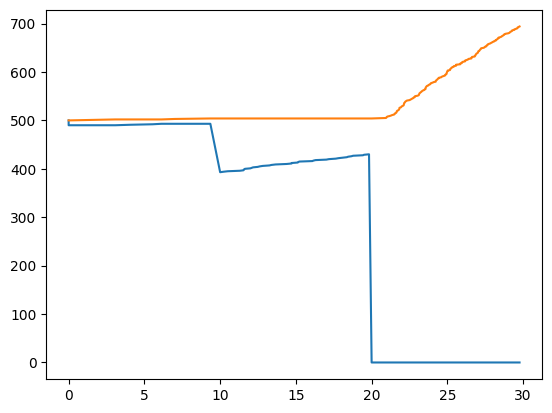

In [26]:
tVals, populationLevels = runPopulation(237, [[500, 500], [1, 0]])

plt.plot(tVals, populationLevels[0, :])
plt.plot(tVals, populationLevels[1, :])